In [1]:
!pip install -U scipy==1.2.0

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [1]:
#For this, we will be using tensorflow version 1
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np
from tensorflow.keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [0]:
height =424
width = 424

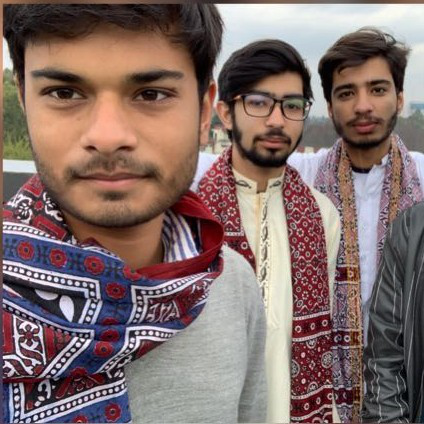

In [4]:
content_image_path = 'pp.jpeg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height,width))
content_image

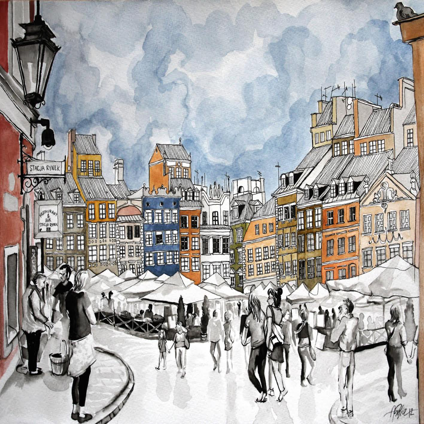

In [5]:
style_image_path = 'style7.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height,width))
style_image

In [6]:
content_array = np.asarray(content_image,dtype='float32')
content_array = np.expand_dims(content_array,axis=0)
print(content_array.shape)

(1, 424, 424, 3)


In [7]:
style_array = np.asarray(style_image,dtype='float32')
style_array = np.expand_dims(style_array,axis=0)
print(style_array.shape)

(1, 424, 424, 3)


Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).

In [0]:
#Some Pre-processing needed to be performed on the Image before imputting to the 
#Vgg16 Model.

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [9]:
content_image = backend.variable(content_array)
style_image   = backend.variable(style_array)
combined_image = backend.placeholder((1,height,width,3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
input_tensor= backend.concatenate([content_image,style_image,combined_image],axis=0)

In [11]:
model = VGG16(include_top=False,weights='imagenet',input_tensor=input_tensor)

In [0]:
layers = {layer.name : layer.output for layer in model.layers}

In [13]:
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 424, 424, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 424, 424, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 212, 212, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 212, 212, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 212, 212, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 106, 106, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 106, 106, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 106, 106, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 106, 106, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 53, 53, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 53, 53, 512) dtype=float32>,
 'b

In [0]:
content_weight = 0.025
style_weight =11.0
total_variation_weight = 1.0

In [0]:
loss = backend.variable(0.)

In [0]:
def content_loss(content,combination):
  return backend.sum(backend.square(combination-content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]
loss = loss + content_loss(content_image_features,combination_features)*content_weight

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(features,backend.transpose(features))
    return gram

In [0]:
def style_loss(style,combination):
  s = gram_matrix(style)
  c = gram_matrix(combination)
  channels = 3
  size = height * width
  return backend.sum(backend.square(s-c))/(4. * (channels ** 2) * (size ** 2))


feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:

  layer_features = layers[layer_name]

  style_image_features = layer_features[1,:,:,:]
  combination_features = layer_features[2,:,:,:]

  style_lo = style_loss(style_image_features,combination_features)
    
  loss=loss+(style_weight/len(feature_layers)*(style_lo))


In [0]:
def total_variation_loss(x):
    a = backend.square(x[:,:height-1,:width-1,:] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a+b,1.25))

loss=loss+total_variation_weight * total_variation_loss(combined_image)

In [20]:
#claculating derivative of combined_image placeholder w.r.t loss.
grads = backend.gradients(loss, combined_image)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# In order to update the grds we have to use an optimizer to find delta grads
#In this case I have used L-BFGS algorithm

outputs = [loss]
outputs += grads
f_outputs = backend.function([combined_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [0]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

In [23]:

iterations =10
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x,min_val,info  = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
  print('Current loss value:', min_val)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 180991360000.0
Iteration 0 completed in 9s
Start of iteration 1
Current loss value: 80479210000.0
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 51519844000.0
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 38310687000.0
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 30397860000.0
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 25516567000.0
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 22786122000.0
Iteration 6 completed in 4s
Start of iteration 7
Current loss value: 21485875000.0
Iteration 7 completed in 4s
Start of iteration 8
Current loss value: 20801473000.0
Iteration 8 completed in 5s
Start of iteration 9
Current loss value: 20312060000.0
Iteration 9 completed in 5s


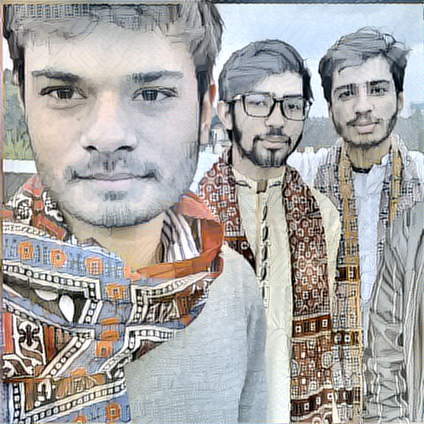

In [24]:
x=x.reshape((height,width,3))
x = x[:,:,::-1]

x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)